##Proyecto Final de Aprendizaje de Máquina Ricardo Figueroa Riestra CU 112714

###"Breaking a Captcha with Machine Learning and Computer Vision Tools"

First we load all the required packages for the development of the project
i) Matplotlib for showing images
ii) Tensorflow for computing Convolutional Neural Networks
iii) CV2 is a computer vision library used in this project to capture the contours of images and separate them
iv) We also load "Image" so we are able to view the processed images by cv2

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt  
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import imutils
import cv2
from imutils.perspective import four_point_transform
from imutils import contours
import os
from PIL import Image, ImageFilter, ImageMath
import pandas as pd
import pytesseract
from random import random
import random as rd
from numpy import array
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import svm

We need to load our train images and labels into data structures. 
Train and test images were obtained from the following URL https://www.kaggle.com/c/ix-captcha-solver/data

In [2]:
imgsTrain1 = []
number_image = []
path = "/home/ricardo/project_directory/pythonVirtualEnv1/train"
for f in os.listdir(path):
    f_int = int(float(f))
    number_image.append(f_int)
    imgsTrain1.append(cv2.imread(os.path.join(path,f)))
    
imgsTrain1 = np.asarray(imgsTrain1)
number_image = np.asarray(number_image)

inds = number_image.argsort()
train_images = imgsTrain1[inds]
labels = np.asarray(pd.read_csv("trainLabels.csv", header = None))
train_labels = np.delete(labels,198,0)

In [3]:
imgs_test1 = []
number_image = []
path = "/home/ricardo/project_directory/pythonVirtualEnv1/test"
for f in os.listdir(path):
    f_int = int(float(f))
    number_image.append(f_int)
    imgs_test1.append(cv2.imread(os.path.join(path,f)))
    
imgs_test1 = np.asarray(imgs_test1)
number_image = np.asarray(number_image)

inds1 = number_image.argsort()
test_images = imgs_test1[inds1]

The manipulation of images by cv2 sometimes changes images, so we should keep another copy of our train images

In [4]:
train_images_copy2 = np.copy(np.asarray(train_images))

In [5]:
test_images_copy2 = np.copy(np.asarray(test_images))

In [6]:
train_images_copy3 = list(np.copy(np.asarray(train_images)))

In [7]:
test_images_copy3 = list(np.copy(np.asarray(test_images)))

In [8]:
train_labels_copy3 = np.copy(np.asarray(train_labels))

In order to test that images were properly loaded, we show the first image of our train image data set followed by the corresponding text label

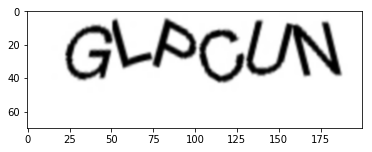

In [9]:
plt.imshow(train_images[0], cmap = 'gray', interpolation = 'bicubic')

In [10]:
train_labels[0]

array([1, 'GLPCUN'], dtype=object)

After properly saving and loading our data, we define a function that will help us separate our images into letters, this works by the following:
i) Obtaining the contours of the image
ii) Boxing each contour into a rectangle box
iii) By defining distance rules between letters, separate each "box" into an independent image. If the measurement of the "box" exceeds certain characteristics (observed in the code), the box is partitioned into a smaller box that will enclose a letter. This can also be done with an alternative boxing method using circles, but we chose the rectangle because it works better.

In [11]:
def encontrar_contornos(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
    (im2, cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    indexes = []
    contour_parts_rect = []
    contour_parts_circ = []
    x_array = []

    for contour in cnts[:2000]:
        #circle
        #(a,b),radius = cv2.minEnclosingCircle(contour)
        #center = (int(a),int(b))
        #radius = int(radius)
        #circulo  = cv2.circle(image,center,radius,(0,255,0),2)
        #contour_parts_circ.append(circulo)
    
        #rectangle
        x, y, w, h = cv2.boundingRect(contour)
        rectangle=[x,y,w,h]
        aspect_ratio = h/w
        area = cv2.contourArea(contour)
        imi = cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        indexes.append(rectangle)
        
        
        if w<35:
            contour_parts_rect.append(im2[y:y+h,x:x+w])
            x_array.append(x)
        
        else:
            if w<=70:
                contour_parts_rect.append(im2[y:y+h,x:x+(w/2)])
                contour_parts_rect.append(im2[y:y+h,x+(w/2):x+w])
                x_array.append(x)
                x_array.append(x+(w/2))
            else:
                if w<90:
                    contour_parts_rect.append(im2[y:y+h,x:x+(w/3)])
                    contour_parts_rect.append(im2[y:y+h,x+(w/3):x+(w/3*2)])
                    contour_parts_rect.append(im2[y:y+h,x+(w/3*2):x+w])
                    x_array.append(x)
                    x_array.append(x+(w/3))
                    x_array.append(x+(w/3*2))
                else:
                    contour_parts_rect.append(im2[y:y+h,x:x+(w/4)])
                    contour_parts_rect.append(im2[y:y+h,x+(w/4):x+(w/4*2)])
                    contour_parts_rect.append(im2[y:y+h,x+(w/4*2):x+(w/4*3)])
                    contour_parts_rect.append(im2[y:y+h,x+(w/4*3):x+(w/4*4)])
                    x_array.append(x)
                    x_array.append(x+(w/4))
                    x_array.append(x+(w/4*2))
                    x_array.append(x+(w/4*3))
            
    x_array = np.asarray(x_array)
    contour_parts_rect = np.asarray(contour_parts_rect)
    inds = x_array.argsort()
    contour_parts_rect = contour_parts_rect[inds]

    return(contour_parts_rect)

We show the first element of our training images copy, to show it is properly saved.

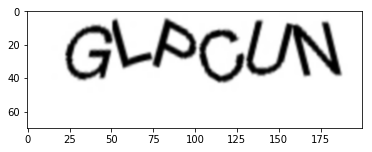

In [12]:
plt.imshow(train_images_copy2[0], cmap = 'gray', interpolation = 'bicubic')

Some smaller parts of the image (that are not letters) are also captured as boxes. This is a mistake caused by the de design of the captcha that has some letters attached by common pixels, thus we define a function that eliminates from our separated set of images the "erronous" boxes. This method also works by defining rules of distance between the letters.

In [13]:
def limpiar_contornos(contornos):
    clean_contornos = []
    for i in range(len(contornos)):
        x = contornos[i].shape[1]
        if x>17:
            if x<50:
                clean_contornos.append(contornos[i])        
    return(clean_contornos)

After defining the functions that separate the images by letter, we should check the effectiveness of our methods by counting the elements separated for each training and test image.

In [14]:
proof = []
contornos_proof = [] 
for image in range(len(train_images)):
    contornos_proof.append(len(limpiar_contornos(encontrar_contornos(train_images[image]))))

In [15]:
elementos_igual_a_seis = contornos_proof.count(6)

In [16]:
proof_test = []
contornos_proof_test = [] 
for image in range(len(test_images)):
    contornos_proof_test.append(len(limpiar_contornos(encontrar_contornos(test_images[image]))))

In [17]:
elementos_igual_a_seis_test = contornos_proof_test.count(6)

In [18]:
elementos_igual_a_seis_test

132

In [19]:
elementos_igual_a_seis

162

In [20]:
len(test_images)

176

In [22]:
len(train_images)

199

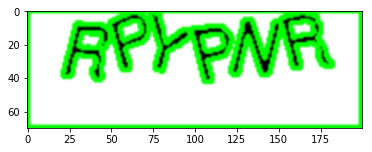

In [54]:
plt.imshow(train_images[17], cmap = 'gray', interpolation = 'bicubic')

In [102]:
proof2 = [] 
for image in range(len(train_images)):
    proof2.append(limpiar_contornos(encontrar_contornos(train_images[image])))

TypeError: Image data can not convert to float

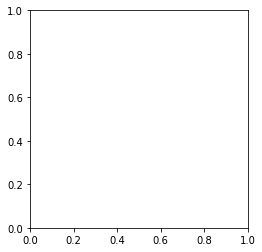

In [104]:
plt.imshow(proof2[1], cmap = 'gray', interpolation = 'bicubic')

The effectiveness of our method for separating each image is the following
a) 162/199 = 81% for training data and 132/176 = 75% for test data.
This effectiveness is only related to the computer vision methods offered by the cv2 package.

After defining our separable letter training images, we save them separately: 

In [27]:
train_set_images = []
train_set_labels = []
for i in range(len(train_images_copy2)):
    if contornos_proof[i] == 6:
        train_set_images.append(train_images_copy2[i])
        train_set_labels.append(train_labels[i])

In [28]:
test_set_images = []
for i in range(len(test_images_copy2)):
    if contornos_proof_test[i] == 6:
        test_set_images.append(test_images_copy2[i])

We should also separate our labels accordingly (train set only)

In [29]:
separated_train_labels = []
train_set_labels = np.asarray(train_set_labels)
for element in train_set_labels[:,1]:
    for character in element:
        separated_train_labels.append(character)

We check that the new train set images have the same lenght as prevoiusly defined by the effectiveness of the computer vision tools.

In [32]:
len(train_set_images)

162

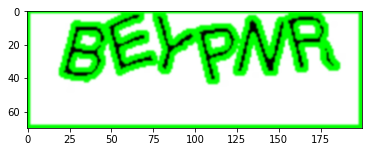

In [53]:
plt.imshow(train_set_images[78], cmap = 'gray', interpolation = 'bicubic')

In [35]:
len(test_set_images)

132

We should check that new set of training images has the proper corresponding label:

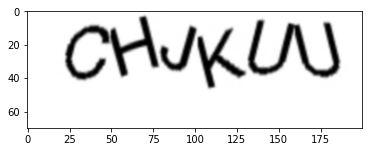

In [36]:
plt.imshow(train_set_images[1], cmap = 'gray', interpolation = 'bicubic')

In [37]:
train_set_labels[1]

array([3, 'CHJKUU'], dtype=object)

Next, we separate each new training letter (image):

In [38]:
separated_train_images = []
for element in train_set_images:
    temporal = limpiar_contornos(encontrar_contornos(element))
    for i in range(len(temporal)):
        separated_train_images.append(temporal[i])

In [39]:
separated_test_images = []
for element in test_set_images:
    temporal = limpiar_contornos(encontrar_contornos(element))
    for i in range(len(temporal)):
        separated_test_images.append(temporal[i])

After separating our images, we should also check that that the number of images is also the same as previously defined:

In [40]:
len(separated_train_images)/6

162

In [41]:
len(separated_test_images)/6

132

Also check if a random letter has the same label: 

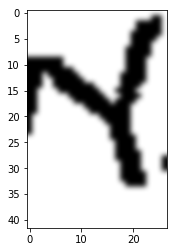

In [118]:
plt.imshow(separated_train_images[67], cmap = 'gray', interpolation = 'bicubic')

In [33]:
separated_train_labels[80]

'J'

Separate letter images have different sizes, so we should define a function to standarize their sizes in order to use machine learning tools.

In [34]:
scaled_train_images = []
for element in separated_train_images:
    element1 = Image.fromarray(element)
    height = element1.size[1]
    width = element1.size[0]
    new_width  = 28
    new_height = new_width * height / width 
    new_height = 28 
    element2 = element1.resize((new_width, new_height), Image.ANTIALIAS)    
    scaled_train_images.append(element2)

In [35]:
scaled_test_images = []
for element in separated_test_images:
    element1 = Image.fromarray(element)
    height = element1.size[1]
    width = element1.size[0]
    new_width  = 28
    new_height = new_width * height / width 
    new_height = 28 
    element2 = element1.resize((new_width, new_height), Image.ANTIALIAS)    
    scaled_test_images.append(element2)

We should check that sizes are the selected and that the new images are keeping their quality: 

In [36]:
for element in scaled_train_images:
    print(element.size)

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(

In [37]:
for element in scaled_test_images:
    print(element.size)

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(

In [38]:
scaled_train_images[12]

In [39]:
separated_train_labels[12]

'P'

Our first Machine Learning tool will be Convolutional Neural Networks, so we should have a lot more training data. This is why why should define a method for replicating the data and perhaps add some noise to the images so we can have a more resilient predictive model. The order of the letter/label should also be randomized.
We also add a technique to rotate the images randomly between 0 and 25 degrees.

In [40]:
randomized_labels_training = []
randomized_images_training = []
copy_factor = 100
i = 0
for element in scaled_train_images:
    randomized_images_training.append(element)
    randomized_labels_training.append(separated_train_labels[i])
    for u in range(0,copy_factor):
        rotate_randomly = rd.randint(-0, 0)
        blur = rd.randint(0, 0)
        element1 = element.filter(ImageFilter.GaussianBlur(blur))
        im2 = element1.convert('RGBA')
        # rotated image
        rot = im2.rotate(rotate_randomly, expand=0)
        # a white image same size as rotated image
        fff = Image.new('RGBA', rot.size, (255,)*4)
        # create a composite image using the alpha layer of rot as a mask
        out = Image.composite(rot, fff, rot)
        randomized_images_training.append(out)
        randomized_labels_training.append(separated_train_labels[i])
    i = i + 1

We should also create more data for testing

In [41]:
randomized_images_training[90002].size

(28, 28)

In [42]:
randomized_labels_training[90000]

'K'

In [43]:
randomized_images_training[90000]

After creating additional data and adding some noise we should also reshuffle the newly created data together with the original training data:

In [9]:
def unison_shuffled_copies(a, b):
    c = list(zip(a, b))
    rd.shuffle(c)
    a, b = zip(*c)
    return(a,b)

And also reshuffle test data with another method (because we do not have test labels)

In [45]:
def shuffle(a):
    c = rd.shuffle(a)
    return c 

In [46]:
randomized_result_train = unison_shuffled_copies(randomized_images_training, randomized_labels_training)
randomized_labels_train_set = randomized_result_train[1]
randomized_images_train_set = randomized_result_train[0]

We check again if labels correspond to images randomly

In [47]:
letter = randomized_images_train_set[9000]

In [48]:
letter

In [49]:
randomized_labels_train_set[9000]

'E'

In [50]:
letter.size

(28, 28)

In [51]:
len(randomized_images_training)

98172

In [52]:
randomized_labels_training[9000]

'N'

We should get the data from the images

We should change the format of each image to a format we can work with in with Tensorflow

Because we do not have labels for the test images we would use part of the training images and labels as test data

In [53]:
index=np.array([1 if random() < 0.75 else 0 for i in range(0,len(randomized_images_training))])

In [54]:
x_train_images = []
x_test_images = []
for i in range(len(index)):
    if index[i] == 1:
        x_train_images.append(randomized_images_training[i])
    else:
        x_test_images.append(randomized_images_training[i])

In [55]:
x_train_labels = np.array(randomized_labels_training)[index==1]

In [56]:
x_test_labels = np.array(randomized_labels_training)[index==0]

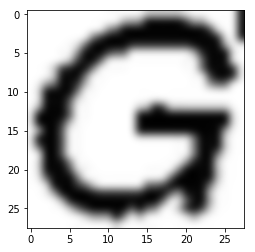

In [57]:
plt.imshow(x_train_images[0], cmap = 'gray', interpolation = 'bicubic')

In [58]:
x_train_labels[0]

'G'

In [59]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [60]:
unique_letters = np.unique(x_train_labels)

In [61]:
unique_letters = list(unique_letters)

In [62]:
unique_letters

['A',
 'B',
 'C',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'R',
 'T',
 'U',
 'X',
 'Y']

In [63]:
unique_letters_test = np.unique(x_test_labels)

In [64]:
unique_letters_test = list(unique_letters_test)

In [65]:
unique_letters_test

['A',
 'B',
 'C',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'R',
 'T',
 'U',
 'X',
 'Y']

In [66]:
unique_numbers_test = np.asarray([i for i in range(len(unique_letters_test))])

In [67]:
unique_numbers_test[17]

17

In [68]:
unique_numbers_test = list(unique_numbers_test)

In [69]:
letter_check_test = np.asarray([unique_letters_test.index(i) for i in x_test_labels])

In [70]:
letter_check_test

array([ 5,  5,  5, ..., 14, 14, 14])

In [71]:
min(letter_check_test)

0

In [72]:
letter_check = np.asarray([unique_letters.index(i) for i in x_train_labels])

In [73]:
x_test_labels[0]

'G'

In [74]:
letter_check_test[0]

5

In [75]:
letter_check

array([ 5,  5,  5, ..., 14, 14, 14])

In [76]:
unique_numbers = np.asarray([i for i in range(len(unique_letters))])

In [77]:
unique_numbers = list(unique_numbers)

In [78]:
letter_check = np.asarray([unique_letters.index(i) for i in x_train_labels])

In [79]:
x_train_labels[0]

'G'

In [80]:
letter_check[0]

5

In [81]:
unique_letters.index("A")

0

In [82]:
unique_numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [83]:
letter_check_test

array([ 5,  5,  5, ..., 14, 14, 14])

In [84]:
x_train_labels[8787]

'M'

In [85]:
x_train_images[8787]

In [86]:
letter_check[7878]

1

In [87]:
x_train_labels[7878]

'B'

In [88]:
x_train_images[7878]

In [89]:
x_train_images1 = []
for i in range(len(x_train_images)):
    im = x_train_images[i]
    x_train_images1.append(array(ImageMath.eval("convert(a,'F')",a = im)))

In [90]:
x_test_images1 = []
for i in range(len(x_test_images)):
    im = x_test_images[i]
    x_test_images1.append(array(ImageMath.eval("convert(a,'F')",a = im)))

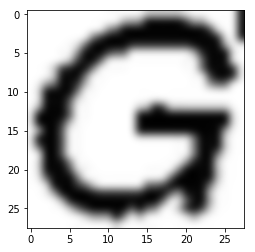

In [91]:
plt.imshow(x_test_images1[0], cmap = 'gray', interpolation = 'bicubic')

In [92]:
x_test_images1 = np.asarray(x_test_images1)

In [93]:
x_train_images1 = np.asarray(x_train_images1)

In [94]:
x_mean = x_test_images1.mean(axis=0) 
x_std = x_test_images1.std(axis=0) 
X_test = (x_test_images1-x_mean)/(x_std+0.00001)

In [95]:
x_mean = x_train_images1.mean(axis=0) 
x_std = x_train_images1.std(axis=0) 
X_train = (x_train_images1-x_mean)/(x_std+0.00001)

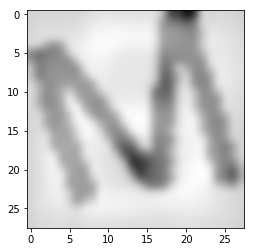

In [96]:
plt.imshow(X_train[8787], cmap = 'gray', interpolation = 'bicubic')

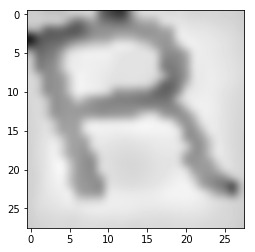

In [97]:
plt.imshow(X_train[7678], cmap = 'gray', interpolation = 'bicubic')

In [98]:
x_train_labels[7678]

'R'

In [99]:
letter_check[7678]

13

In [100]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.01, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=18)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=18)
  loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [99]:
# Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': '/tmp/mnist_convnet_model', '_save_summary_steps': 100}


In [100]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

In [101]:
X_train = np.asarray(X_train)

In [102]:
X_test = np.asarray(X_test)

## Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=letter_check,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

In [106]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test},
    y=letter_check_test,
    num_epochs=1,
    shuffle=False)
eval_results = classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2017-12-08-15:52:36
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-22137
INFO:tensorflow:Finished evaluation at 2017-12-08-15:52:57
INFO:tensorflow:Saving dict for global step 22137: accuracy = 0.999019, global_step = 22137, loss = 0.00185575
{'loss': 0.0018557484, 'global_step': 22137, 'accuracy': 0.99901915}


For a second model, we will now try to adjut our data to a Random Forest

In [175]:
new_X_train = X_train.reshape((len(X_train), -1))

In [176]:
new_X_test = X_test.reshape((len(X_test), -1))

In [177]:
scalerx = preprocessing.StandardScaler().fit(new_X_train)
X_train=scalerx.transform(new_X_train)
X_test=scalerx.transform(new_X_test)

In [178]:
RForest=RandomForestClassifier(criterion='gini', min_samples_split=3,n_estimators=100)
RForest.fit(new_X_train,letter_check) 
pred=RForest.predict(new_X_test) 
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(letter_check_test,pred))
print(confusion_matrix(letter_check_test,pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1222
          1       1.00      1.00      1.00      1518
          2       1.00      1.00      1.00      1580
          3       1.00      1.00      1.00      1258
          4       1.00      1.00      1.00      1283
          5       1.00      1.00      1.00      1269
          6       1.00      1.00      1.00      1362
          7       1.00      1.00      1.00      1448
          8       1.00      1.00      1.00      1346
          9       1.00      1.00      1.00      1590
         10       1.00      1.00      1.00      1056
         11       1.00      1.00      1.00      1358
         12       1.00      1.00      1.00      1582
         13       1.00      1.00      1.00      1463
         14       1.00      1.00      1.00      1488
         15       1.00      1.00      1.00      1184
         16       1.00      1.00      1.00      1465
         17       1.00      1.00      1.00   

It look Random Forest does well capture to capture the individual letters.

In [181]:
tree=DecisionTreeClassifier()
tree.fit(new_X_train,letter_check)
pred=tree.predict(new_X_test) 
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(letter_check_test,pred))
print(confusion_matrix(letter_check_test,pred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1222
          1       1.00      1.00      1.00      1518
          2       0.98      1.00      0.99      1580
          3       1.00      1.00      1.00      1258
          4       0.93      0.98      0.95      1283
          5       1.00      1.00      1.00      1269
          6       1.00      0.92      0.96      1362
          7       0.98      1.00      0.99      1448
          8       1.00      0.98      0.99      1346
          9       0.99      1.00      0.99      1590
         10       1.00      0.92      0.96      1056
         11       0.95      1.00      0.97      1358
         12       1.00      0.97      0.98      1582
         13       0.98      0.97      0.97      1463
         14       0.95      1.00      0.97      1488
         15       1.00      0.97      0.99      1184
         16       1.00      1.00      1.00      1465
         17       1.00      0.98      0.99   

Replicar full captchas

In [24]:
train_labels_full = train_labels_copy3[:,1]

In [25]:
randomized_labels_training_full = []
randomized_images_training_full = []
copy_factor = 100
i = 0
for element in train_images_copy3:
    randomized_images_training_full.append(element)
    randomized_labels_training_full.append(train_labels_full[i])
    for u in range(0,copy_factor):
        randomized_images_training_full.append(element)
        randomized_labels_training_full.append(train_labels_full[i])
    i = i + 1

In [26]:
len(randomized_images_training_full)

20099

In [27]:
len(randomized_labels_training_full)

20099

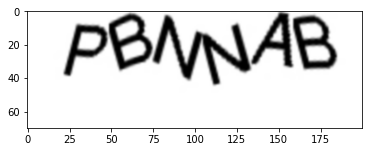

In [28]:
plt.imshow(randomized_images_training_full[1899], cmap = 'gray', interpolation = 'bicubic')

In [29]:
randomized_labels_training_full[1899]

'PBNNAB'

In [30]:
randomized_full_data = unison_shuffled_copies(randomized_images_training_full, randomized_labels_training_full)

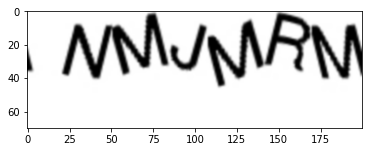

In [31]:
plt.imshow(randomized_full_data[0][3], cmap = 'gray', interpolation = 'bicubic')

In [32]:
randomized_full_data[1][3]

'NMJMRM'

In [33]:
full_training_images = randomized_full_data[0][:]
full_training_labels = randomized_full_data[1][:]

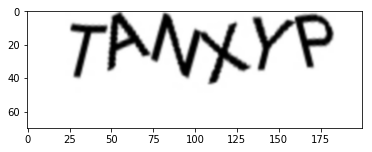

In [34]:
plt.imshow(full_training_images[1], cmap = 'gray', interpolation = 'bicubic')

In [35]:
full_training_labels[1]

'TANXYP'

In [36]:
full_training_images = np.asarray(full_training_images)

In [38]:
index_full=np.array([1 if random() < 0.75 else 0 for i in range(0,len(full_training_images))])

In [39]:
x_train_images_full = []
x_test_images_full = []
for i in range(len(index_full)):
    if index_full[i] == 1:
        x_train_images_full.append(full_training_images[i])
    else:
        x_test_images_full.append(full_training_images[i])

In [46]:
x_train_labels_full = np.array(full_training_labels)[index_full==1]
x_test_labels_full = np.array(full_training_labels)[index_full==0]

In [48]:
new_X_train_full = np.asarray(x_train_images_full).reshape((len(x_train_images_full), -1))
new_X_test_full = np.asarray(x_test_images_full).reshape((len(x_test_images_full), -1))

In [54]:
x_train_images1_full = []
for i in range(len(new_X_train_full)):
    im = x_train_images_full[i]
    img = Image.fromarray(im,"RGB")
    x_train_images1_full.append(array(ImageMath.eval("convert(a,'F')",a = img)))

In [58]:
x_test_images1_full = []
for i in range(len(new_X_test_full)):
    im = x_test_images_full[i]
    img = Image.fromarray(im,"RGB")
    x_test_images1_full.append(array(ImageMath.eval("convert(a,'F')",a = img)))

In [59]:
new_X_train_full1 = np.asarray(x_train_images1_full).reshape((len(x_train_images1_full), -1))
new_X_test_full1 = np.asarray(x_test_images1_full).reshape((len(x_test_images1_full), -1))

In [60]:
scalerx = preprocessing.StandardScaler().fit(new_X_train_full1)
X_train_full_captcha=scalerx.transform(new_X_train_full1)
X_test_full_captcha=scalerx.transform(new_X_test_full1)

In [64]:
tree_full=DecisionTreeClassifier()
tree_full.fit(X_train_full_captcha,x_train_labels_full)
pred=tree_full.predict(X_test_full_captcha) 
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(x_test_labels_full,pred))
print(confusion_matrix(x_test_labels_full,pred))

             precision    recall  f1-score   support

     ABXTXM       1.00      1.00      1.00        22
     AFCUFA       1.00      1.00      1.00        24
     AGHHLT       1.00      1.00      1.00        27
     AHAFGT       1.00      1.00      1.00        28
     AJJLKR       1.00      1.00      1.00        26
     ALECKG       1.00      1.00      1.00        30
     ANENGM       1.00      1.00      1.00        24
     AYUTCU       1.00      1.00      1.00        27
     BBBUUB       1.00      1.00      1.00        31
     BBGEGN       1.00      1.00      1.00        27
     BCTNPF       1.00      1.00      1.00        25
     BEEAHL       1.00      1.00      1.00        27
     BEYPNR       1.00      1.00      1.00        25
     BFXGYJ       1.00      1.00      1.00        30
     BGFJNL       1.00      1.00      1.00        25
     BGUYFP       1.00      1.00      1.00        27
     BJMLKE       1.00      1.00      1.00        26
     BKKPFJ       1.00      1.00      1.00   

[[22  0  0 ...,  0  0  0]
 [ 0 24  0 ...,  0  0  0]
 [ 0  0 27 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 31  0  0]
 [ 0  0  0 ...,  0 15  0]
 [ 0  0  0 ...,  0  0 23]]
